# Imports


In [47]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import math

# Funções criadas pelo professor

In [48]:
#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):

    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))

    return dist

In [49]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho

    return ener

In [50]:
@jit(nopython=True)
def newpath(N,path):

    # define uma nova caminhada

    newpath = np.zeros(N,dtype=np.int16)

    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):        # inverte o sentido em que percorre o caminho entre os indices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]

    return newpath,ini,fin



In [51]:
@jit(nopython=True)
def mcstep(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)

    np1,ini,fin = newpath(N,path) # propoe um novo caminho

    # determina a diferença de energia
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado até o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1

    return en,path,best_e,best_p

# Funções Adicionadas

In [61]:
def manysteps(num_pontos, path, dist, temp_inicial=10, temp_final=0.0001, step=0.8, temp_iter = 100):
    energys_arr=[]
    paths_arr=[]
    temp_arr=[]
    en=custo(num_pontos, path, dist)
    best_e=en
    best_p=path
    temp=temp_inicial
    while(temp>=temp_final):
        for _ in range(temp_iter):
            en, path, best_e, best_p=mcstep(num_pontos, 1/temp, en, path, best_e, best_p, dist)
            energys_arr.append(en)
            paths_arr.append(path)
        temp_arr.append(temp)
        temp=temp*step
    return energys_arr, paths_arr, best_e, best_p, temp_arr

In [53]:
def plot_path(num_pontos, melhor_caminho, x ,y, title='Melhor Caminho'):
    plt.scatter(x,y)
    for i in range(num_pontos):
        plt.text(x[i], y[i], i, fontsize=7, ha='right')

    for i in range(num_pontos):
        pos1=melhor_caminho[i%num_pontos]
        pos2=melhor_caminho[(i+1)%num_pontos]
        plt.plot([x[pos1], x[pos2]], [y[pos1], y[pos2]], color='blue')
    plt.title(title)
    plt.show()

In [54]:
def plot_many(N, caminhos,energias, x,y, num_graphs=10):
    iteracoes=len(caminhos)
    for i in range(0,iteracoes, math.floor(iteracoes/num_graphs)):
        plot_path(N, caminhos[i], x,y, "Passo "+str(i)+" de Monte Carlo com energia "+str(round(energias[i],2)))


In [62]:
def plot_temp_energy(temp_arr, energias, temp_iter = 100):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Passos de Monte Carlo")
    ax1.set_ylabel('Energia', color='tab:red')
    ax1.plot(range(0,len(energias)), energias, color='tab:red', marker='', label='Energia')
    ax1.tick_params(axis='y', labelcolor='tab:red')


    ax2 = ax1.twinx()

    ax2.set_ylabel('Temperatura', color='tab:blue')
    ax2.plot(range(0,len(energias), temp_iter), temp_arr, color='tab:blue', marker='', label='Temperatura')
    ax2.tick_params(axis='y', labelcolor='tab:blue')


    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Temperatura e Energia por passos de Monte Carlo')
    plt.show()

# Testes

Primeiramente, criamos um conjunto de N pontos iniciais aleatórios com coordenadas entre 0 e 1, e a partir deles criou-se um caminho inicial aleatório.

In [56]:
N=1060       # Numero de cidades

rng = np.random.default_rng(seed=42)   # Define as posições aleatórias das cidades
x=rng.random(N)
y=rng.random(N)

# define o caminho que liga as cidades (inicialmente a sequencia como foi criada)
path_ini = np.zeros(N,dtype=np.int16)
for i in range(N):
    path_ini[i]=i

Em seguida, com a função "distances" disponibilizada pelo professor, geramos uma matriz de distâncias, e aplicamos o método de Monte Carlo a partir do caminho inicial buscando minimizar a distância total percorrida no caminho.

Para realizarmos esse processo definimos uma temperatura inicial, um step - o qual representa por quanto a temperatura será multiplicada em cada redução - e uma temperatura final.  Em cada iteração da função many_steps,  $temp\_iter$
passos de Monte Carlo são executados e a temperatura é reduziada de acordo com step passado. Esse processo para somente quanto a temperatura atinge a temperatura final.


In [57]:
dist=distances(N,x,y)
energias, caminhos, melhor_energia, melhor_caminho, temp_arr = manysteps(N,path_ini, dist, temp_inicial=10.0, step=0.99, temp_final=0.0001)


##Plot da evolução dos caminhos de acordo com a função manysteps

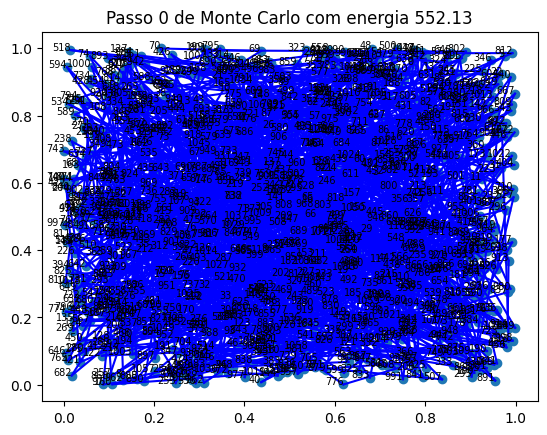

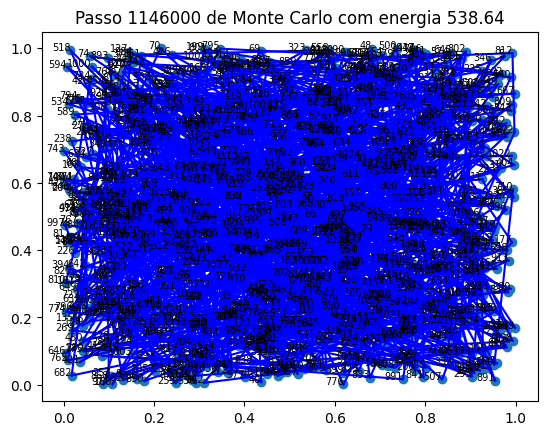

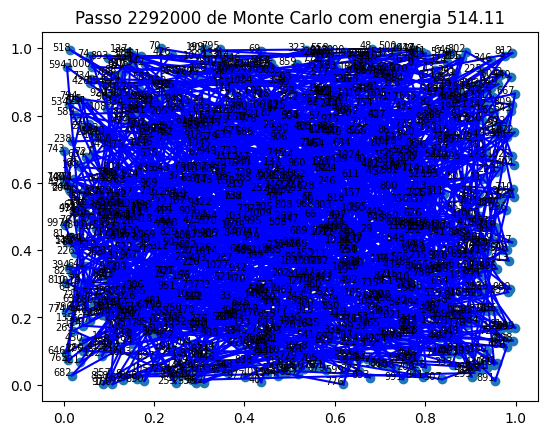

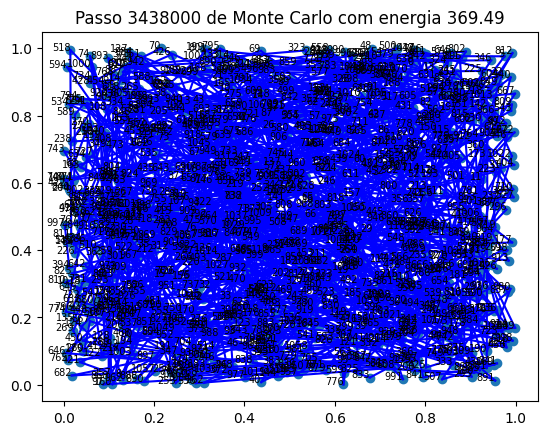

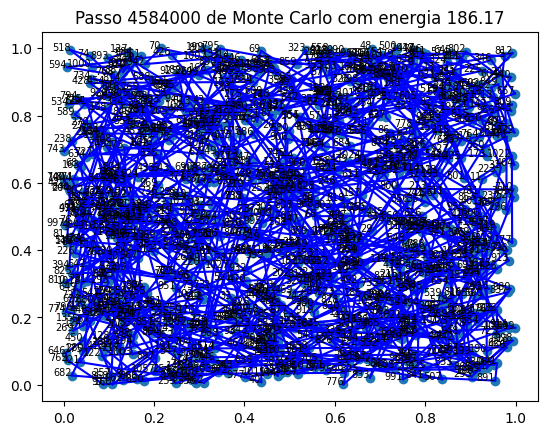

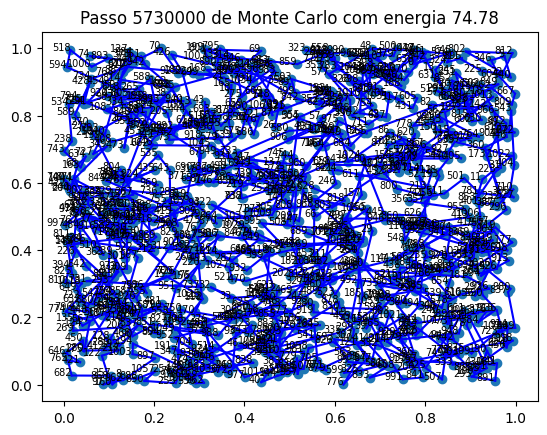

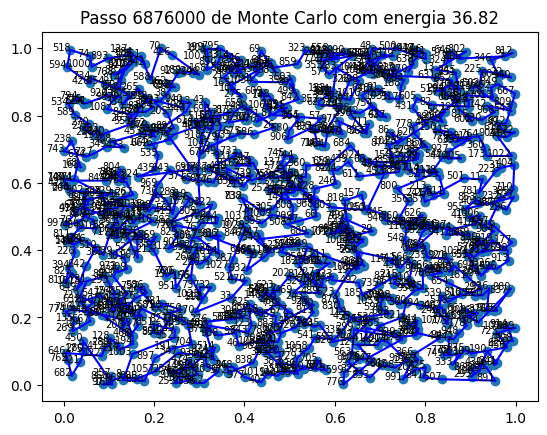

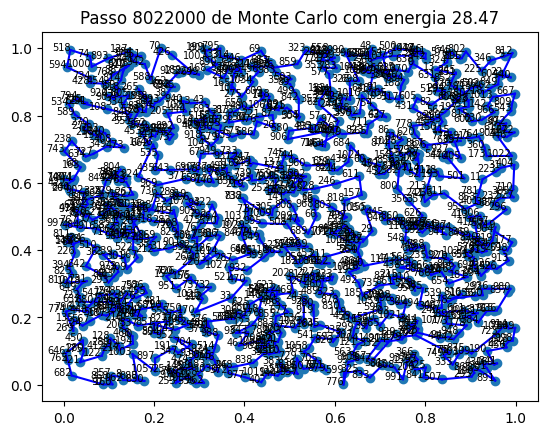

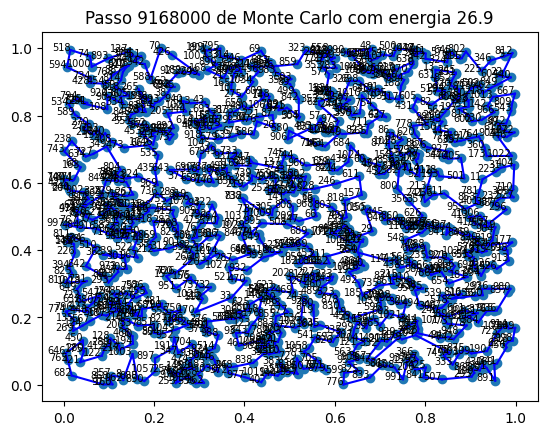

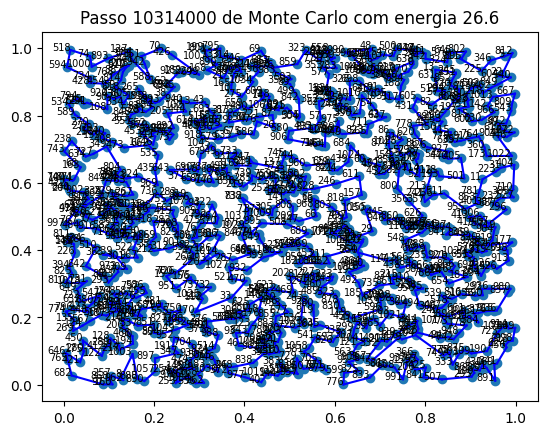

In [58]:
plot_many(N,caminhos,energias,x,y)

## Plot do caminho encontrado pelo algoritmo

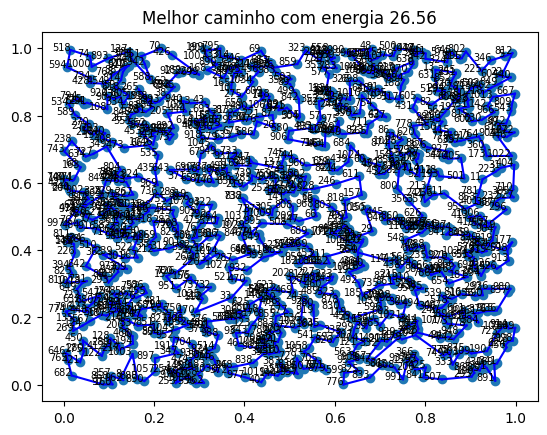

In [59]:
plot_path(N,melhor_caminho, x,y, title="Melhor caminho com energia "+str(round(melhor_energia,2)))

## Plot da evolução da temperatura e da energia

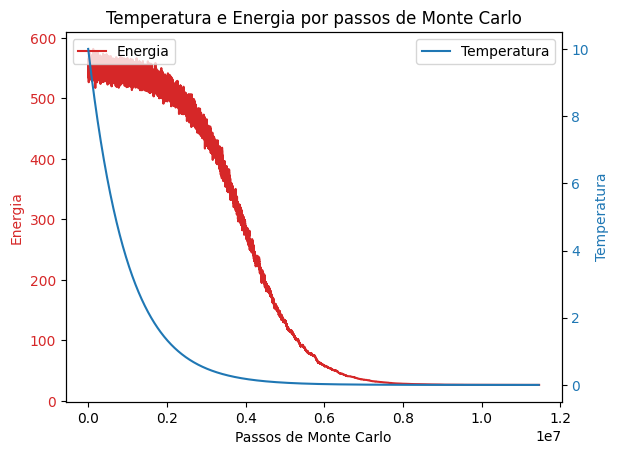

In [60]:
plot_temp_energy(temp_arr, energias)

# Discussão/Resultados